In [1]:
#general libraries
import torch
from torch import nn
from torchvision import datasets, transforms
import math
import time
import logging
import matplotlib.pyplot as plt
import itertools
import numpy as np
from tqdm import tqdm
import torchvision.utils as vutils
import os
import textwrap
import torch.optim as optim

#optuna
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#optuna dashboard
import optuna_dashboard
from optuna_dashboard.artifact import get_artifact_path
from optuna_dashboard.preferential import create_study
from optuna_dashboard import register_preference_feedback_component
from optuna_dashboard.preferential.samplers.gp import PreferentialGPSampler

torch.manual_seed(111)

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/mayank_khulbe_farmart_co/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mayank_khulbe_farmart_co/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def get_mnist_loaders(train_batch_size, test_batch_size):
    """Get MNIST data loaders"""
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [5]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels, criterion, d_optimizer):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.unsqueeze(1))
    real_score = outputs

    outputs = discriminator(fake_images)
    fake_loss = criterion(outputs, fake_labels.unsqueeze(1))
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()

    d_optimizer.step()
    return d_loss, real_score, fake_score

In [6]:
def train_generator(generator, discriminator_outputs, real_labels, criterion, g_optimizer):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.unsqueeze(1))
    g_loss.backward()

    g_optimizer.step()
    return g_loss

In [7]:
# Plot grid of 9 images from generator after each epoch
def generate_new_images(generator, sample_images, latent_dim, img_dir):
    fixed_noise = torch.randn(sample_images, latent_dim).to(device)  # Sample 15 images
    fake_images = generator(fixed_noise).to(device)

    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(fake_images, nrow=5, padding=1, normalize=True).cpu().numpy(),
            (1, 2, 0)
        )
    )
    plt.savefig(img_dir)
    plt.show()
    plt.close()

In [8]:
def train_GANs(study: optuna.Study,
               artifact_store: FileSystemArtifactStore):

    trial = study.ask() #start a trial

    print(f"running trial number: {trial.number}")

    latent_dim = 128

    #define the generator and the discriminator
    discriminator = Discriminator().to(device=device)
    generator = Generator().to(device=device)

    cfg = {
        "train_batch_size": trial.suggest_categorical("train_batch_size", [64, 128]),
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "num_epochs": 100,
        "lr": trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "optimizer": trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    }

    #define the loader
    batch_size = cfg["train_batch_size"]
    train_loader, _ = get_mnist_loaders(batch_size, batch_size)


    #define the optimizers
    lr = cfg['lr']
    optimizer_name = cfg['optimizer']
    d_optimizer = getattr(optim, optimizer_name)(discriminator.parameters(), lr=lr)  # Instantiate optimizer from name
    g_optimizer = getattr(optim, optimizer_name)(generator.parameters(), lr=lr)  # Instantiate optimizer from name

    #define the criterion
    criterion = nn.BCELoss()

    print(f"Batch Size: {batch_size}\nLearning Rate: {lr}\nOptimizer: {optimizer_name}")

    for epoch in range(cfg['num_epochs']):

        print(f"running epoch number: {epoch}")

        for n, (images, _) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            real_labels = torch.ones(images.size(0)).to(device)

            noise = torch.randn(images.size(0), latent_dim).to(device)
            fake_images = generator(noise)
            fake_labels = torch.zeros(images.size(0)).to(device)

            # Train the discriminator
            d_loss, real_score, fake_score = train_discriminator(discriminator, images,
                                                                 real_labels, fake_images, fake_labels,
                                                                  criterion, d_optimizer)

            noise = torch.randn(images.size(0), latent_dim).to(device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images)

            # Train the generator
            g_loss = train_generator(generator, outputs, real_labels, criterion, g_optimizer)

            if (n+1) % len(train_loader) == 0:

                print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, '
                    'D(x): %.2f, D(G(z)): %.2f'
                    % (epoch + 1, cfg['num_epochs'], n + 1, len(train_loader), d_loss.item(), g_loss.item(),
                        real_score.mean().item(), fake_score.mean().item()))

    img_path = f"tmp/generated_image-{trial.number}.png"
    generate_new_images(generator, 30, latent_dim, img_path)

    user_attr_key = "generated-image"
    artifact_id = upload_artifact(trial, img_path, artifact_store)
    register_preference_feedback_component(study, "artifact", user_attr_key)
    trial.set_user_attr(user_attr_key, artifact_id)

In [9]:
def start_optimization(artifact_store: FileSystemArtifactStore):
    # 1. Create Study
    storage = "sqlite:///pref_opt.db"
    study = create_study(
        n_generate=4,
        study_name="Preferential Optimization",
        storage=storage,
        sampler=PreferentialGPSampler(),
        load_if_exists=True,
    )

    while True:
    # If study.should_generate() returns False, the generator waits for human evaluation.
        if not study.should_generate():
            time.sleep(0.1)  # Avoid busy-loop
            continue

        train_GANs(study, artifact_store)

        

In [10]:
def main():
    # tmp_path = os.path.join(os.path.dirname(__file__), "tmp")
    # Get the absolute path to the current notebook file
    notebook_dir = os.getcwd()

    # Create the absolute path to the "tmp" folder
    tmp_path = os.path.join(notebook_dir, "tmp")

    # 1. Create Artifact Store
    # artifact_path = os.path.join(os.path.dirname(__file__), "artifact")
    artifact_path = os.path.join(notebook_dir, "artifact")
    artifact_store = FileSystemArtifactStore(artifact_path)

    print(f"paths : {tmp_path}, {artifact_path}")

    if not os.path.exists(artifact_path):
        os.mkdir(artifact_path)

    if not os.path.exists(tmp_path):
        os.mkdir(tmp_path)

    # 2. Run optimize loop
    start_optimization(artifact_store)

/var/tmp/ipykernel_214395/3673421781.py:12: ExperimentalWarning: FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.
  artifact_store = FileSystemArtifactStore(artifact_path)


paths : /home/mayank_khulbe_farmart_co/fmt/Optuna/experiments/tmp, /home/mayank_khulbe_farmart_co/fmt/Optuna/experiments/artifact


[I 2024-03-25 04:55:54,343] A new study created in RDB with name: Preferential Optimization
/home/mayank_khulbe_farmart_co/.local/lib/python3.9/site-packages/optuna_dashboard/preferential/_study.py:297: FutureWarning: system_attrs has been deprecated in v3.1.0. This feature will be removed in v5.0.0. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  return len(active_trials) < get_n_generate(self._study.system_attrs)
/home/mayank_khulbe_farmart_co/.local/lib/python3.9/site-packages/optuna_dashboard/preferential/samplers/gp.py:471: UserWarning: Dynamic search space detected. Falling back to RandomSampler.
  warnings.warn(


running trial number: 0
Batch Size: 128
Learning Rate: 0.0007937819065498264
Optimizer: Adam
running epoch number: 0


469it [00:26, 17.79it/s]


Epoch [1/100], Step[469/469], d_loss: 0.6401, g_loss: 6.0696, D(x): 0.87, D(G(z)): 0.31
running epoch number: 1


469it [00:25, 18.52it/s]


Epoch [2/100], Step[469/469], d_loss: 0.5584, g_loss: 4.2254, D(x): 0.83, D(G(z)): 0.03
running epoch number: 2


469it [00:25, 18.20it/s]


Epoch [3/100], Step[469/469], d_loss: 0.2909, g_loss: 3.7679, D(x): 0.90, D(G(z)): 0.06
running epoch number: 3


469it [00:25, 18.65it/s]


Epoch [4/100], Step[469/469], d_loss: 0.2559, g_loss: 3.2507, D(x): 0.93, D(G(z)): 0.09
running epoch number: 4


469it [00:25, 18.39it/s]


Epoch [5/100], Step[469/469], d_loss: 0.1562, g_loss: 4.3611, D(x): 0.95, D(G(z)): 0.07
running epoch number: 5


469it [00:25, 18.06it/s]


Epoch [6/100], Step[469/469], d_loss: 0.2752, g_loss: 3.6175, D(x): 0.90, D(G(z)): 0.08
running epoch number: 6


469it [00:25, 18.07it/s]


Epoch [7/100], Step[469/469], d_loss: 0.3854, g_loss: 2.0124, D(x): 0.91, D(G(z)): 0.17
running epoch number: 7


469it [00:26, 17.80it/s]


Epoch [8/100], Step[469/469], d_loss: 0.3684, g_loss: 2.8334, D(x): 0.85, D(G(z)): 0.09
running epoch number: 8


469it [00:25, 18.59it/s]


Epoch [9/100], Step[469/469], d_loss: 0.4962, g_loss: 2.2511, D(x): 0.81, D(G(z)): 0.10
running epoch number: 9


469it [00:25, 18.16it/s]


Epoch [10/100], Step[469/469], d_loss: 0.5632, g_loss: 2.0501, D(x): 0.83, D(G(z)): 0.15
running epoch number: 10


469it [00:25, 18.40it/s]


Epoch [11/100], Step[469/469], d_loss: 0.7090, g_loss: 2.0119, D(x): 0.85, D(G(z)): 0.27
running epoch number: 11


469it [00:25, 18.39it/s]


Epoch [12/100], Step[469/469], d_loss: 0.5522, g_loss: 2.5767, D(x): 0.80, D(G(z)): 0.17
running epoch number: 12


469it [00:25, 18.26it/s]


Epoch [13/100], Step[469/469], d_loss: 0.6907, g_loss: 1.9624, D(x): 0.76, D(G(z)): 0.22
running epoch number: 13


469it [00:25, 18.33it/s]


Epoch [14/100], Step[469/469], d_loss: 0.7079, g_loss: 1.9512, D(x): 0.74, D(G(z)): 0.21
running epoch number: 14


469it [00:25, 18.28it/s]


Epoch [15/100], Step[469/469], d_loss: 0.6172, g_loss: 2.1128, D(x): 0.80, D(G(z)): 0.21
running epoch number: 15


469it [00:25, 18.76it/s]


Epoch [16/100], Step[469/469], d_loss: 0.7739, g_loss: 2.0049, D(x): 0.74, D(G(z)): 0.23
running epoch number: 16


469it [00:25, 18.18it/s]


Epoch [17/100], Step[469/469], d_loss: 0.7568, g_loss: 1.7659, D(x): 0.74, D(G(z)): 0.26
running epoch number: 17


469it [00:25, 18.40it/s]


Epoch [18/100], Step[469/469], d_loss: 0.8980, g_loss: 1.2900, D(x): 0.70, D(G(z)): 0.30
running epoch number: 18


469it [00:25, 18.26it/s]


Epoch [19/100], Step[469/469], d_loss: 0.9550, g_loss: 1.5349, D(x): 0.65, D(G(z)): 0.30
running epoch number: 19


469it [00:25, 18.40it/s]


Epoch [20/100], Step[469/469], d_loss: 0.9164, g_loss: 1.3940, D(x): 0.68, D(G(z)): 0.30
running epoch number: 20


469it [00:25, 18.41it/s]


Epoch [21/100], Step[469/469], d_loss: 1.0045, g_loss: 1.4380, D(x): 0.73, D(G(z)): 0.37
running epoch number: 21


469it [00:25, 18.44it/s]


Epoch [22/100], Step[469/469], d_loss: 1.1331, g_loss: 1.0951, D(x): 0.70, D(G(z)): 0.41
running epoch number: 22


469it [00:25, 18.62it/s]


Epoch [23/100], Step[469/469], d_loss: 0.9308, g_loss: 1.6903, D(x): 0.71, D(G(z)): 0.35
running epoch number: 23


469it [00:25, 18.11it/s]


Epoch [24/100], Step[469/469], d_loss: 0.9818, g_loss: 1.2451, D(x): 0.64, D(G(z)): 0.32
running epoch number: 24


469it [00:25, 18.57it/s]


Epoch [25/100], Step[469/469], d_loss: 1.0767, g_loss: 1.2883, D(x): 0.62, D(G(z)): 0.34
running epoch number: 25


469it [00:25, 18.41it/s]


Epoch [26/100], Step[469/469], d_loss: 1.1167, g_loss: 1.1961, D(x): 0.62, D(G(z)): 0.37
running epoch number: 26


469it [00:25, 18.29it/s]


Epoch [27/100], Step[469/469], d_loss: 1.1524, g_loss: 1.3152, D(x): 0.63, D(G(z)): 0.37
running epoch number: 27


469it [00:24, 18.80it/s]


Epoch [28/100], Step[469/469], d_loss: 1.0499, g_loss: 1.2584, D(x): 0.64, D(G(z)): 0.36
running epoch number: 28


469it [00:25, 18.19it/s]


Epoch [29/100], Step[469/469], d_loss: 1.2015, g_loss: 1.1012, D(x): 0.66, D(G(z)): 0.42
running epoch number: 29


469it [00:25, 18.53it/s]


Epoch [30/100], Step[469/469], d_loss: 1.2263, g_loss: 0.9045, D(x): 0.60, D(G(z)): 0.41
running epoch number: 30


469it [00:25, 18.35it/s]


Epoch [31/100], Step[469/469], d_loss: 1.0934, g_loss: 1.0761, D(x): 0.58, D(G(z)): 0.33
running epoch number: 31


469it [00:25, 18.54it/s]


Epoch [32/100], Step[469/469], d_loss: 1.1300, g_loss: 1.0889, D(x): 0.60, D(G(z)): 0.40
running epoch number: 32


469it [00:25, 18.49it/s]


Epoch [33/100], Step[469/469], d_loss: 1.1428, g_loss: 1.0973, D(x): 0.60, D(G(z)): 0.39
running epoch number: 33


469it [00:25, 18.20it/s]


Epoch [34/100], Step[469/469], d_loss: 1.0553, g_loss: 1.1236, D(x): 0.62, D(G(z)): 0.35
running epoch number: 34


469it [00:25, 18.64it/s]


Epoch [35/100], Step[469/469], d_loss: 1.1151, g_loss: 1.0692, D(x): 0.63, D(G(z)): 0.41
running epoch number: 35


469it [00:25, 18.24it/s]


Epoch [36/100], Step[469/469], d_loss: 1.1821, g_loss: 0.9855, D(x): 0.56, D(G(z)): 0.39
running epoch number: 36


469it [00:25, 18.49it/s]


Epoch [37/100], Step[469/469], d_loss: 1.1962, g_loss: 0.9071, D(x): 0.59, D(G(z)): 0.42
running epoch number: 37


469it [00:25, 18.36it/s]


Epoch [38/100], Step[469/469], d_loss: 1.0901, g_loss: 1.1676, D(x): 0.65, D(G(z)): 0.39
running epoch number: 38


469it [00:25, 18.40it/s]


Epoch [39/100], Step[469/469], d_loss: 1.1286, g_loss: 0.9131, D(x): 0.62, D(G(z)): 0.44
running epoch number: 39


469it [00:25, 18.64it/s]


Epoch [40/100], Step[469/469], d_loss: 1.1668, g_loss: 0.9812, D(x): 0.56, D(G(z)): 0.39
running epoch number: 40


469it [00:25, 18.26it/s]


Epoch [41/100], Step[469/469], d_loss: 1.2167, g_loss: 1.0309, D(x): 0.55, D(G(z)): 0.38
running epoch number: 41


469it [00:25, 18.28it/s]


Epoch [42/100], Step[469/469], d_loss: 1.3338, g_loss: 0.9533, D(x): 0.49, D(G(z)): 0.41
running epoch number: 42


469it [00:25, 18.19it/s]


Epoch [43/100], Step[469/469], d_loss: 1.2011, g_loss: 1.0549, D(x): 0.59, D(G(z)): 0.39
running epoch number: 43


469it [00:25, 18.58it/s]


Epoch [44/100], Step[469/469], d_loss: 1.3079, g_loss: 0.9252, D(x): 0.57, D(G(z)): 0.46
running epoch number: 44


469it [00:25, 18.14it/s]


Epoch [45/100], Step[469/469], d_loss: 1.2172, g_loss: 1.0365, D(x): 0.59, D(G(z)): 0.41
running epoch number: 45


469it [00:25, 18.58it/s]


Epoch [46/100], Step[469/469], d_loss: 1.1950, g_loss: 0.9432, D(x): 0.58, D(G(z)): 0.42
running epoch number: 46


469it [00:25, 18.46it/s]


Epoch [47/100], Step[469/469], d_loss: 1.2357, g_loss: 0.9496, D(x): 0.57, D(G(z)): 0.43
running epoch number: 47


469it [00:25, 18.14it/s]


Epoch [48/100], Step[469/469], d_loss: 1.3097, g_loss: 1.0085, D(x): 0.50, D(G(z)): 0.40
running epoch number: 48


469it [00:25, 18.54it/s]


Epoch [49/100], Step[469/469], d_loss: 1.3455, g_loss: 1.0339, D(x): 0.50, D(G(z)): 0.40
running epoch number: 49


469it [00:25, 18.06it/s]


Epoch [50/100], Step[469/469], d_loss: 1.2255, g_loss: 1.0245, D(x): 0.61, D(G(z)): 0.44
running epoch number: 50


469it [00:25, 18.56it/s]


Epoch [51/100], Step[469/469], d_loss: 1.3628, g_loss: 0.8663, D(x): 0.57, D(G(z)): 0.49
running epoch number: 51


469it [00:25, 18.31it/s]


Epoch [52/100], Step[469/469], d_loss: 1.1683, g_loss: 0.8111, D(x): 0.61, D(G(z)): 0.43
running epoch number: 52


469it [00:25, 18.47it/s]


Epoch [53/100], Step[469/469], d_loss: 1.3459, g_loss: 0.8863, D(x): 0.57, D(G(z)): 0.48
running epoch number: 53


469it [00:25, 18.46it/s]


Epoch [54/100], Step[469/469], d_loss: 1.3107, g_loss: 0.7951, D(x): 0.60, D(G(z)): 0.50
running epoch number: 54


469it [00:25, 18.10it/s]


Epoch [55/100], Step[469/469], d_loss: 1.2991, g_loss: 0.9525, D(x): 0.53, D(G(z)): 0.43
running epoch number: 55


469it [00:25, 18.48it/s]


Epoch [56/100], Step[469/469], d_loss: 1.1664, g_loss: 0.9484, D(x): 0.58, D(G(z)): 0.39
running epoch number: 56


469it [00:25, 18.10it/s]


Epoch [57/100], Step[469/469], d_loss: 1.2975, g_loss: 1.0010, D(x): 0.58, D(G(z)): 0.46
running epoch number: 57


469it [00:25, 18.37it/s]


Epoch [58/100], Step[469/469], d_loss: 1.1806, g_loss: 0.9848, D(x): 0.56, D(G(z)): 0.41
running epoch number: 58


469it [00:25, 18.46it/s]


Epoch [59/100], Step[469/469], d_loss: 1.2839, g_loss: 0.9736, D(x): 0.55, D(G(z)): 0.42
running epoch number: 59


469it [00:25, 18.48it/s]


Epoch [60/100], Step[469/469], d_loss: 1.1307, g_loss: 0.9761, D(x): 0.61, D(G(z)): 0.41
running epoch number: 60


469it [00:25, 18.43it/s]


Epoch [61/100], Step[469/469], d_loss: 1.2095, g_loss: 0.8709, D(x): 0.55, D(G(z)): 0.40
running epoch number: 61


469it [00:25, 18.40it/s]


Epoch [62/100], Step[469/469], d_loss: 1.2702, g_loss: 0.9743, D(x): 0.50, D(G(z)): 0.38
running epoch number: 62


469it [00:25, 18.66it/s]


Epoch [63/100], Step[469/469], d_loss: 1.2551, g_loss: 0.9763, D(x): 0.56, D(G(z)): 0.42
running epoch number: 63


469it [00:26, 17.95it/s]


Epoch [64/100], Step[469/469], d_loss: 1.2435, g_loss: 0.9200, D(x): 0.59, D(G(z)): 0.46
running epoch number: 64


469it [00:24, 18.88it/s]


Epoch [65/100], Step[469/469], d_loss: 1.3912, g_loss: 0.8889, D(x): 0.52, D(G(z)): 0.46
running epoch number: 65


469it [00:24, 18.98it/s]


Epoch [66/100], Step[469/469], d_loss: 1.2590, g_loss: 1.0282, D(x): 0.54, D(G(z)): 0.42
running epoch number: 66


469it [00:24, 19.28it/s]


Epoch [67/100], Step[469/469], d_loss: 1.1906, g_loss: 0.9345, D(x): 0.60, D(G(z)): 0.45
running epoch number: 67


469it [00:23, 19.82it/s]


Epoch [68/100], Step[469/469], d_loss: 1.3222, g_loss: 0.9124, D(x): 0.55, D(G(z)): 0.44
running epoch number: 68


469it [00:24, 19.43it/s]


Epoch [69/100], Step[469/469], d_loss: 1.3138, g_loss: 0.9146, D(x): 0.60, D(G(z)): 0.49
running epoch number: 69


469it [00:23, 20.09it/s]


Epoch [70/100], Step[469/469], d_loss: 1.2325, g_loss: 0.9673, D(x): 0.55, D(G(z)): 0.40
running epoch number: 70


469it [00:23, 20.18it/s]


Epoch [71/100], Step[469/469], d_loss: 1.2873, g_loss: 1.0012, D(x): 0.50, D(G(z)): 0.40
running epoch number: 71


469it [00:24, 19.53it/s]


Epoch [72/100], Step[469/469], d_loss: 1.2075, g_loss: 1.0083, D(x): 0.58, D(G(z)): 0.43
running epoch number: 72


469it [00:23, 20.27it/s]


Epoch [73/100], Step[469/469], d_loss: 1.2354, g_loss: 1.0154, D(x): 0.54, D(G(z)): 0.41
running epoch number: 73


469it [00:23, 20.01it/s]


Epoch [74/100], Step[469/469], d_loss: 1.2518, g_loss: 0.9405, D(x): 0.53, D(G(z)): 0.41
running epoch number: 74


469it [00:23, 20.20it/s]


Epoch [75/100], Step[469/469], d_loss: 1.2518, g_loss: 1.0649, D(x): 0.52, D(G(z)): 0.40
running epoch number: 75


469it [00:22, 20.48it/s]


Epoch [76/100], Step[469/469], d_loss: 1.2600, g_loss: 0.9612, D(x): 0.53, D(G(z)): 0.41
running epoch number: 76


469it [00:23, 20.05it/s]


Epoch [77/100], Step[469/469], d_loss: 1.3097, g_loss: 0.9936, D(x): 0.56, D(G(z)): 0.45
running epoch number: 77


469it [00:23, 20.37it/s]


Epoch [78/100], Step[469/469], d_loss: 1.2721, g_loss: 1.0256, D(x): 0.56, D(G(z)): 0.43
running epoch number: 78


469it [00:23, 19.93it/s]


Epoch [79/100], Step[469/469], d_loss: 1.1903, g_loss: 0.9828, D(x): 0.59, D(G(z)): 0.43
running epoch number: 79


469it [00:22, 20.44it/s]


Epoch [80/100], Step[469/469], d_loss: 1.2164, g_loss: 0.8478, D(x): 0.61, D(G(z)): 0.45
running epoch number: 80


469it [00:23, 20.16it/s]


Epoch [81/100], Step[469/469], d_loss: 1.2766, g_loss: 0.8330, D(x): 0.58, D(G(z)): 0.47
running epoch number: 81


469it [00:23, 20.03it/s]


Epoch [82/100], Step[469/469], d_loss: 1.2674, g_loss: 0.9962, D(x): 0.54, D(G(z)): 0.40
running epoch number: 82


469it [00:22, 20.58it/s]


Epoch [83/100], Step[469/469], d_loss: 1.2170, g_loss: 0.9545, D(x): 0.58, D(G(z)): 0.43
running epoch number: 83


469it [00:23, 20.39it/s]


Epoch [84/100], Step[469/469], d_loss: 1.3557, g_loss: 0.9636, D(x): 0.53, D(G(z)): 0.45
running epoch number: 84


469it [00:23, 19.89it/s]


Epoch [85/100], Step[469/469], d_loss: 1.3114, g_loss: 0.9189, D(x): 0.57, D(G(z)): 0.45
running epoch number: 85


469it [00:23, 20.34it/s]


Epoch [86/100], Step[469/469], d_loss: 1.1792, g_loss: 1.0357, D(x): 0.55, D(G(z)): 0.39
running epoch number: 86


469it [00:23, 19.70it/s]


Epoch [87/100], Step[469/469], d_loss: 1.3000, g_loss: 0.8432, D(x): 0.58, D(G(z)): 0.46
running epoch number: 87


469it [00:23, 20.29it/s]


Epoch [88/100], Step[469/469], d_loss: 1.2972, g_loss: 0.9632, D(x): 0.52, D(G(z)): 0.41
running epoch number: 88


469it [00:23, 20.30it/s]


Epoch [89/100], Step[469/469], d_loss: 1.3520, g_loss: 0.9451, D(x): 0.53, D(G(z)): 0.43
running epoch number: 89


469it [00:23, 19.84it/s]


Epoch [90/100], Step[469/469], d_loss: 1.2187, g_loss: 0.8382, D(x): 0.57, D(G(z)): 0.42
running epoch number: 90


469it [00:23, 20.22it/s]


Epoch [91/100], Step[469/469], d_loss: 1.2279, g_loss: 1.0428, D(x): 0.55, D(G(z)): 0.39
running epoch number: 91


469it [00:23, 20.00it/s]


Epoch [92/100], Step[469/469], d_loss: 1.2458, g_loss: 0.8972, D(x): 0.59, D(G(z)): 0.45
running epoch number: 92


469it [00:23, 20.29it/s]


Epoch [93/100], Step[469/469], d_loss: 1.1792, g_loss: 0.9059, D(x): 0.58, D(G(z)): 0.42
running epoch number: 93


469it [00:23, 20.34it/s]


Epoch [94/100], Step[469/469], d_loss: 1.1738, g_loss: 1.0549, D(x): 0.57, D(G(z)): 0.38
running epoch number: 94


469it [00:23, 20.20it/s]


Epoch [95/100], Step[469/469], d_loss: 1.3540, g_loss: 0.9956, D(x): 0.52, D(G(z)): 0.43
running epoch number: 95


469it [00:22, 20.62it/s]


Epoch [96/100], Step[469/469], d_loss: 1.1614, g_loss: 1.0085, D(x): 0.56, D(G(z)): 0.39
running epoch number: 96


469it [00:23, 20.19it/s]


Epoch [97/100], Step[469/469], d_loss: 1.1890, g_loss: 0.9369, D(x): 0.61, D(G(z)): 0.45
running epoch number: 97


469it [00:23, 20.30it/s]


Epoch [98/100], Step[469/469], d_loss: 1.1850, g_loss: 0.9355, D(x): 0.59, D(G(z)): 0.42
running epoch number: 98


469it [00:22, 20.58it/s]


Epoch [99/100], Step[469/469], d_loss: 1.2357, g_loss: 0.9260, D(x): 0.58, D(G(z)): 0.43
running epoch number: 99


469it [00:23, 20.24it/s]


Epoch [100/100], Step[469/469], d_loss: 1.2022, g_loss: 1.0964, D(x): 0.58, D(G(z)): 0.41


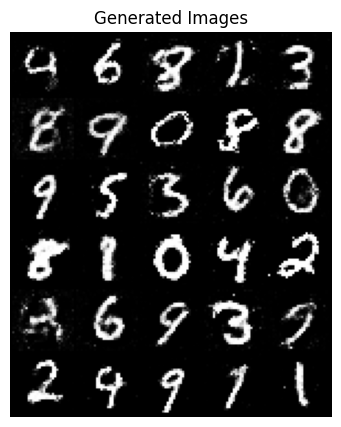

/var/tmp/ipykernel_214395/2031151001.py:73: ExperimentalWarning: upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.
  artifact_id = upload_artifact(trial, img_path, artifact_store)


running trial number: 1
Batch Size: 64
Learning Rate: 2.311456554956886e-05
Optimizer: Adam
running epoch number: 0


938it [00:32, 28.55it/s]


Epoch [1/100], Step[938/938], d_loss: 0.2373, g_loss: 2.1324, D(x): 0.95, D(G(z)): 0.16
running epoch number: 1


938it [00:33, 28.35it/s]


Epoch [2/100], Step[938/938], d_loss: 0.0753, g_loss: 5.0352, D(x): 0.98, D(G(z)): 0.05
running epoch number: 2


938it [00:33, 28.13it/s]


Epoch [3/100], Step[938/938], d_loss: 0.0411, g_loss: 5.4931, D(x): 0.98, D(G(z)): 0.02
running epoch number: 3


938it [00:33, 28.15it/s]


Epoch [4/100], Step[938/938], d_loss: 0.0217, g_loss: 6.2716, D(x): 0.99, D(G(z)): 0.01
running epoch number: 4


938it [00:33, 28.00it/s]


Epoch [5/100], Step[938/938], d_loss: 0.0113, g_loss: 6.2774, D(x): 0.99, D(G(z)): 0.01
running epoch number: 5


938it [00:33, 28.23it/s]


Epoch [6/100], Step[938/938], d_loss: 0.0052, g_loss: 6.7390, D(x): 1.00, D(G(z)): 0.00
running epoch number: 6


938it [00:33, 28.20it/s]


Epoch [7/100], Step[938/938], d_loss: 0.0063, g_loss: 7.8705, D(x): 1.00, D(G(z)): 0.01
running epoch number: 7


938it [00:32, 28.67it/s]


Epoch [8/100], Step[938/938], d_loss: 0.0213, g_loss: 6.5472, D(x): 0.99, D(G(z)): 0.01
running epoch number: 8


938it [00:33, 28.02it/s]


Epoch [9/100], Step[938/938], d_loss: 0.0010, g_loss: 8.3724, D(x): 1.00, D(G(z)): 0.00
running epoch number: 9


938it [00:33, 27.75it/s]


Epoch [10/100], Step[938/938], d_loss: 0.0439, g_loss: 10.9843, D(x): 0.98, D(G(z)): 0.00
running epoch number: 10


938it [00:33, 27.80it/s]


Epoch [11/100], Step[938/938], d_loss: 0.3665, g_loss: 9.9016, D(x): 0.97, D(G(z)): 0.00
running epoch number: 11


938it [00:33, 28.38it/s]


Epoch [12/100], Step[938/938], d_loss: 0.1264, g_loss: 13.1757, D(x): 0.97, D(G(z)): 0.00
running epoch number: 12


938it [00:33, 27.90it/s]


Epoch [13/100], Step[938/938], d_loss: 0.0058, g_loss: 8.7305, D(x): 1.00, D(G(z)): 0.01
running epoch number: 13


938it [00:33, 28.03it/s]


Epoch [14/100], Step[938/938], d_loss: 0.0015, g_loss: 9.8615, D(x): 1.00, D(G(z)): 0.00
running epoch number: 14


938it [00:33, 27.83it/s]


Epoch [15/100], Step[938/938], d_loss: 0.0034, g_loss: 10.5353, D(x): 1.00, D(G(z)): 0.00
running epoch number: 15


938it [00:35, 26.76it/s]


Epoch [16/100], Step[938/938], d_loss: 0.0087, g_loss: 6.3275, D(x): 1.00, D(G(z)): 0.01
running epoch number: 16


938it [00:35, 26.61it/s]


Epoch [17/100], Step[938/938], d_loss: 0.0029, g_loss: 8.9028, D(x): 1.00, D(G(z)): 0.00
running epoch number: 17


938it [00:33, 28.21it/s]


Epoch [18/100], Step[938/938], d_loss: 0.0006, g_loss: 11.6030, D(x): 1.00, D(G(z)): 0.00
running epoch number: 18


938it [00:32, 28.47it/s]


Epoch [19/100], Step[938/938], d_loss: 0.0014, g_loss: 9.5215, D(x): 1.00, D(G(z)): 0.00
running epoch number: 19


938it [00:33, 27.81it/s]


Epoch [20/100], Step[938/938], d_loss: 0.0026, g_loss: 9.3374, D(x): 1.00, D(G(z)): 0.00
running epoch number: 20


938it [00:32, 28.53it/s]


Epoch [21/100], Step[938/938], d_loss: 0.0004, g_loss: 13.0762, D(x): 1.00, D(G(z)): 0.00
running epoch number: 21


938it [00:33, 27.85it/s]


Epoch [22/100], Step[938/938], d_loss: 0.0009, g_loss: 10.3469, D(x): 1.00, D(G(z)): 0.00
running epoch number: 22


938it [00:33, 27.66it/s]


Epoch [23/100], Step[938/938], d_loss: 0.0013, g_loss: 11.8971, D(x): 1.00, D(G(z)): 0.00
running epoch number: 23


938it [00:33, 28.20it/s]


Epoch [24/100], Step[938/938], d_loss: 0.0001, g_loss: 11.3874, D(x): 1.00, D(G(z)): 0.00
running epoch number: 24


938it [00:33, 28.07it/s]


Epoch [25/100], Step[938/938], d_loss: 0.0015, g_loss: 10.5387, D(x): 1.00, D(G(z)): 0.00
running epoch number: 25


938it [00:33, 27.90it/s]


Epoch [26/100], Step[938/938], d_loss: 0.0001, g_loss: 15.2477, D(x): 1.00, D(G(z)): 0.00
running epoch number: 26


938it [00:33, 28.04it/s]


Epoch [27/100], Step[938/938], d_loss: 0.0362, g_loss: 9.9617, D(x): 0.98, D(G(z)): 0.00
running epoch number: 27


938it [00:32, 28.45it/s]


Epoch [28/100], Step[938/938], d_loss: 0.0107, g_loss: 10.6185, D(x): 0.99, D(G(z)): 0.00
running epoch number: 28


938it [00:33, 28.19it/s]


Epoch [29/100], Step[938/938], d_loss: 0.0003, g_loss: 17.3992, D(x): 1.00, D(G(z)): 0.00
running epoch number: 29


938it [00:33, 28.26it/s]


Epoch [30/100], Step[938/938], d_loss: 0.0049, g_loss: 9.7262, D(x): 1.00, D(G(z)): 0.00
running epoch number: 30


938it [00:33, 28.12it/s]


Epoch [31/100], Step[938/938], d_loss: 0.0259, g_loss: 10.2618, D(x): 1.00, D(G(z)): 0.02
running epoch number: 31


938it [00:33, 28.32it/s]


Epoch [32/100], Step[938/938], d_loss: 0.0045, g_loss: 23.4196, D(x): 1.00, D(G(z)): 0.00
running epoch number: 32


938it [00:33, 28.09it/s]


Epoch [33/100], Step[938/938], d_loss: 0.0049, g_loss: 12.2261, D(x): 1.00, D(G(z)): 0.00
running epoch number: 33


938it [00:33, 27.84it/s]


Epoch [34/100], Step[938/938], d_loss: 0.0002, g_loss: 16.0079, D(x): 1.00, D(G(z)): 0.00
running epoch number: 34


938it [00:33, 28.27it/s]


Epoch [35/100], Step[938/938], d_loss: 0.0008, g_loss: 11.6871, D(x): 1.00, D(G(z)): 0.00
running epoch number: 35


938it [00:33, 27.86it/s]


Epoch [36/100], Step[938/938], d_loss: 0.0122, g_loss: 8.9186, D(x): 1.00, D(G(z)): 0.01
running epoch number: 36


418it [00:14, 28.79it/s]

In [11]:
if __name__ == "__main__":
    main()